## Siamese network
This example shows how to build a Siamese NN in TensorFlow and use it to learn distance metric and embedding

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

Define a function, that will generate pairs of observations and their labels (0 - same, 1 - different)

In [2]:
def generate_pairs(data, labels):
    '''Generates positive and negative training examples
    in 1:1 ratio
    '''
    classes = np.unique(labels).astype(int)
    class_indices = [np.where(labels == i)[0] for i in classes]
    pairs = []
    pair_labels = []
    
    #for each class
    for class_ in classes:
        # iterate over other classes
        for aux_class_ in [i for i in classes if i != class_]:
            # for every sample in the class
            for cl_idx in class_indices[class_]:
                # randomly choose a sample from another class
                aux_cl_idx = np.random.choice(class_indices[aux_class_])
                pairs += [[data[cl_idx], data[aux_cl_idx]]]
                # and randomly choose a sample from same class
                same_cl_idx = np.random.choice(class_indices[class_])
                pairs += [[data[cl_idx], data[same_cl_idx]]]
                pair_labels += [0.0, 1.0]
    return np.array(pairs), np.array(pair_labels)


Dataset, used in this example is unnormalized, while NN requires normalized input. We will perform normalization to the range [0,1] by subtracting minimum value and dividing by maximum.

In [3]:
def norm_func(x, a=0, b=1):
    return ((b - a) * (x - min(x))) / (max(x) - min(x)) + a


def normalize(x, y=None):
    x = np.apply_along_axis(norm_func, axis=1, arr=x)
    mask = ~np.isnan(x).any(axis=1)
    if y is not None:
        return x[mask], y[mask]
    else:
        return x[mask]


Load the dataset, containing surface-enhanced Raman spectra, collected in different laboratories using various methods (https://zenodo.org/record/3572359).

We will use method as our target variable

In [4]:
data = pd.read_csv("../ILSdata.csv")
datax = data.drop(['labcode', 'substrate', 'laser', 'method', 'sample', 'type', 'conc',
                   'batch', 'replica'], axis=1)
datax = datax.fillna(0)  # dataset contains NaNs, fill them with zero
# convert category names to integer labels
labels = data['method'].astype("category").cat.codes.values

Dataset is unnormalized, normalize it to the $[0,1]$ range.

In [5]:
datax = normalize(datax)


Split data into training and testing subsets and generate labelled pairs

In [6]:
datax_train, datax_test, labels_train, labels_test = train_test_split(datax, labels, test_size=0.3)

pairs_train, y_train = generate_pairs(datax_train, labels_train)
pairs_test, y_test = generate_pairs(datax_test, labels_test)

Define needed constants - dimensionality of network input and embedding space, leaking coefficient, dropout rate

In [7]:
inp_dim = datax.shape[1]
K_emb = 2
a = 0.1
k = 0.3

Define simple feed-forward model, which will form the main part of Siamese network 

In [8]:
inp = Input(shape=(inp_dim,))

x = Dense(100)(inp)
x = LeakyReLU(a)(x)
x = Dropout(k)(x)

x = Dense(50)(x)
x = LeakyReLU(a)(x)
x = Dropout(k)(x)

out = Dense(K_emb, activation="linear")(x)

shared_model = Model(inp, out)

Define two two inputs for the pair of feature vectors. Outputs are obtained by applying the above-defined on the inputs.

In [9]:
inp_a = Input(shape=(inp_dim,))
inp_b = Input(shape=(inp_dim,))

out_a = shared_model(inp_a)
out_b = shared_model(inp_b)

Define Euclidean distance metric.

In [10]:
def distance(a, b):
    return tf.norm(a - b, axis=-1)

And build the Siamese network as mapping from pair of inputs into the distance

In [11]:
dist = distance(out_a, out_b)
siamese = Model([inp_a, inp_b], [dist])

Now implement contrastive loss, given by equation 

$$\mathcal{{L}}(y,d)=\begin{cases}
\frac{1}{2}\text{max}(d-m_{intra},0)^{2} & \text{if }y=0\\
\frac{1}{2}\text{max}(m_{inter}-d,0)^{2} & \text{if }y=1
\end{cases}$$ 

$d-m_{intra}$ and $d-m_{inter}$ are chosen to be equal to 1 and 2 respectively.

In [12]:
def contrastive_loss(y_true, y_pred):
    # y_true - labels (0 if different, 1 if same)
    # y_pred - distances
    margin_intra = 1.0
    margin_inter = 2.0
    loss_intra = tf.math.square(tf.math.maximum(y_pred - margin_intra, 0.0))
    loss_inter = tf.math.square(tf.math.maximum(margin_inter - y_pred, 0.0))
    return tf.math.reduce_mean(y_true * loss_intra + (1.0 - y_true) * loss_inter)

Compile the network with contrative loss and adam optimizer.

In [13]:
siamese.compile(loss=contrastive_loss, optimizer="adam")

And finally train it for 50 epochs. Since pair creation is stochastic it is useful to recreate pair few times during training, thus model is trained 8 times for 10 epochs.

In [14]:
for i in range(8):
    siamese.fit([pairs_train[:, 0], pairs_train[:, 1]], y_train,
                           batch_size=128,
                           validation_data=[[pairs_test[:, 0], pairs_test[:, 1]], y_test],
                           epochs=10)
    pairs_train, y_train = generate_pairs(datax_train, labels_train)


Train on 24610 samples, validate on 10550 samples
Epoch 1/10
24610/24610 [==============================] - 1s 43us/sample - loss: 0.4109 - val_loss: 0.3154
Epoch 2/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.2998 - val_loss: 0.2475
Epoch 3/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.2487 - val_loss: 0.1942
Epoch 4/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.2101 - val_loss: 0.1710
Epoch 5/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.1787 - val_loss: 0.1277
Epoch 6/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.1520 - val_loss: 0.1130
Epoch 7/10
24610/24610 [==============================] - 1s 24us/sample - loss: 0.1258 - val_loss: 0.0818
Epoch 8/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.1147 - val_loss: 0.0636
Epoch 9/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.1016 - val_

Epoch 4/10
24610/24610 [==============================] - 1s 24us/sample - loss: 0.0217 - val_loss: 0.0108
Epoch 5/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.0193 - val_loss: 0.0070
Epoch 6/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.0159 - val_loss: 0.0070
Epoch 7/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.0186 - val_loss: 0.0104
Epoch 8/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.0177 - val_loss: 0.0105
Epoch 9/10
24610/24610 [==============================] - 1s 25us/sample - loss: 0.0198 - val_loss: 0.0089
Epoch 10/10
24610/24610 [==============================] - 1s 24us/sample - loss: 0.0189 - val_loss: 0.0077


Tune the plotting style for slightly better visualization

In [15]:
matplotlib.style.use("ggplot")
matplotlib.rcParams['figure.figsize'] = (8,6)


And map validation data to the embedding space. It is important to note that shared_model was trained as a part of siamese model, but can be used standalone to perform such mapping.

Finally, plot the obtained mapping. It is clear from the picure that even simple model can learn mapping which efficiently discriminates data, colleced by various methods. It is noteworthy that the model was not fed with actual class labels, but only with same/different indicator.

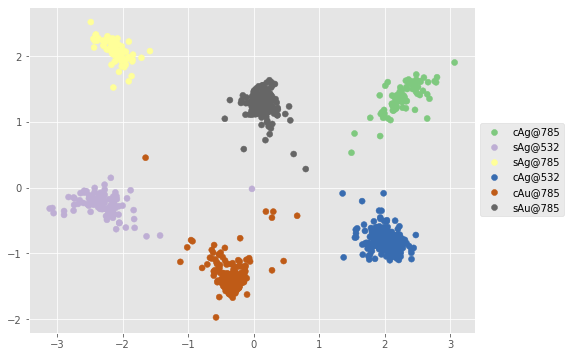

In [16]:
emb = shared_model.predict(datax_test)
scat = plt.scatter(emb[:, 0], emb[:, 1], c=labels_test, cmap="Accent")
plt.legend(scat.legend_elements()[0], data['method'].unique(), loc="center left", bbox_to_anchor=(1,0.5))
plt.show()

Now lets test the learnt distance metric. For this take a single spectrum, repeart it $N$ times, where $N$ is dataset size and process with siamese model to get distances of the spectrum of interest to all others.

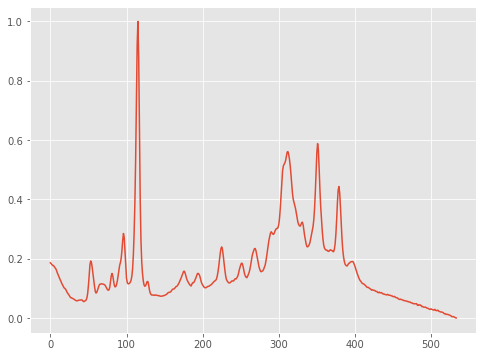

In [17]:
spec = datax_test[0]
plt.plot(spec)
spec_rep = np.repeat(spec[np.newaxis,:], datax.shape[0], axis=0)
distances =  siamese.predict([spec_rep, datax])

Find the order of spectra, sorted by ascending distance

In [18]:
order = np.argsort(distances)

And plot few similar spectra. It must be pointed out that some of them are actually very far in $L^2$ metric, for example, but for Siamese network they are very similar.

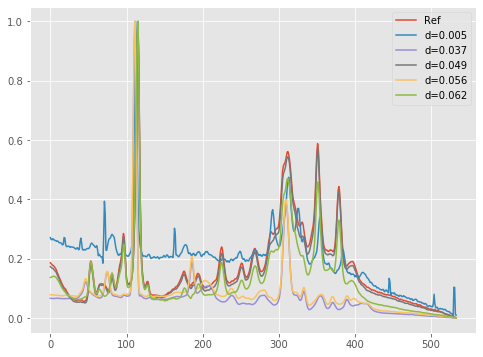

In [19]:
plt.plot(spec, label="Ref")
for i in range(1, 100, 20):
    plt.plot(datax[order[i]], label="d={:.3f}".format(distances[order[i]]))
plt.legend()